In [137]:
import os, sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import xml.etree.ElementTree as ET

In [138]:
# Count the number of images on the different folders downloaded
# Open RDD2020 then open test1, test2 and train and on each folder count the number of images on the images folder

num_images_2020 = {}

for folder in ['test1', 'test2', 'train']:
    for region in ['Czech', 'India', 'Japan']:
        path = f'../RDD2020/{folder}/{region}/images/'

        # Add the number of images or initialize it
        if region not in num_images_2020:
            num_images_2020[region] = {}
        if 'test' not in num_images_2020[region]:
            num_images_2020[region]['test'] = 0
        if 'train' not in num_images_2020[region]:
            num_images_2020[region]['train'] = 0

        num_images_2020[region]['test' if 'test' in folder else 'train'] += len(os.listdir(path))

for region in num_images_2020:
    num_images_2020[region]['total'] = num_images_2020[region]['test'] + num_images_2020[region]['train']

num_images_2020

{'Czech': {'test': 709, 'train': 2829, 'total': 3538},
 'India': {'test': 1959, 'train': 7706, 'total': 9665},
 'Japan': {'test': 2627, 'train': 10506, 'total': 13133}}

In [139]:
# Open RDD2022 then open images and count the number of images for each region (this time I don't have anotations for the test images)

num_images_2022 = {}

for region in ['China_Drone', 'China_MotorBike', 'Czech', 'India', 'Japan', 'United_States']:
    path = f'../RDD2022/images/{region}/'

    if region not in num_images_2022:
        num_images_2022[region] = {}

    for folder in os.listdir(path):
        if folder == '.DS_Store': continue # Ignore this MacOS file
        if folder not in num_images_2022:
            num_images_2022[region][folder] = 0

        num_images_2022[region][folder] += len(os.listdir(path + folder + '/images/'))

for region in num_images_2022:
    num_images_2022[region]['total'] = sum(num_images_2022[region].values())

num_images_2022


{'China_Drone': {'train': 2401, 'total': 2401},
 'China_MotorBike': {'test': 500, 'train': 1977, 'total': 2477},
 'Czech': {'test': 709, 'train': 2829, 'total': 3538},
 'India': {'test': 1959, 'train': 7706, 'total': 9665},
 'Japan': {'test': 2627, 'train': 10506, 'total': 13133},
 'United_States': {'test': 1200, 'train': 4805, 'total': 6005}}

### It looks like the images for Czech, India and Japan are the same in both datasets which means we can use the test anotations from the old dataset in the new one. However, I don't have the test annotations for the other countries so I will have to split those myself.

In [140]:
# Total number of images anotated and not anotated in RDD2022.

total_images_2022 = 0
total_anotated_2022 = 0
total_not_anotated_2022 = 0

for region in num_images_2022:
    total_images_2022 += num_images_2022[region]['total']
    if region in ['Czech', 'India', 'Japan']:
        total_anotated_2022 += num_images_2022[region]['total']
    else:
        if 'test' in num_images_2022[region]:
            total_not_anotated_2022 += num_images_2022[region]['test']
        total_anotated_2022 += num_images_2022[region]['train']

total_images_2022, total_anotated_2022, total_not_anotated_2022

(37219, 35519, 1700)

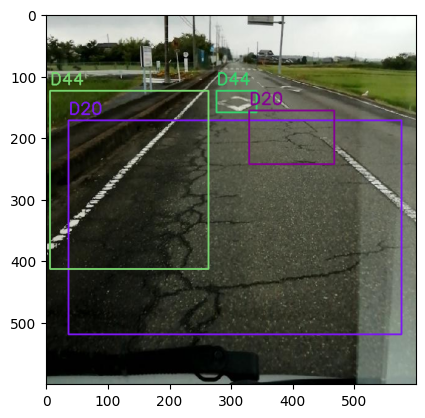

In [141]:
# Lets open an image and show the anotations for it
# United_States_000001, Japan_000015
image_name = 'Japan_000015'
region = image_name.split('_')[0]

image_path = '../RDD2022/images/' + region + '/train/images/' + image_name + '.jpg'
anotation_xml_path = '../RDD2022/images/' + region + '/train/annotations/xmls/' + image_name + '.xml'

image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

tree = ET.parse(anotation_xml_path)
root = tree.getroot()

for obj in root.findall('object'):
    bndbox = obj.find('bndbox')
    xmin = int(bndbox.find('xmin').text)
    ymin = int(bndbox.find('ymin').text)
    xmax = int(bndbox.find('xmax').text)
    ymax = int(bndbox.find('ymax').text)
    name = obj.find('name').text
    # Random color for each object
    color = tuple([int(x) for x in np.random.randint(0, 255, size=3)])
    cv2.rectangle(image, (xmin, ymin), (xmax, ymax), color, 2)
    cv2.putText(image, name, (xmin, ymin - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, color, 2)

plt.imshow(image)

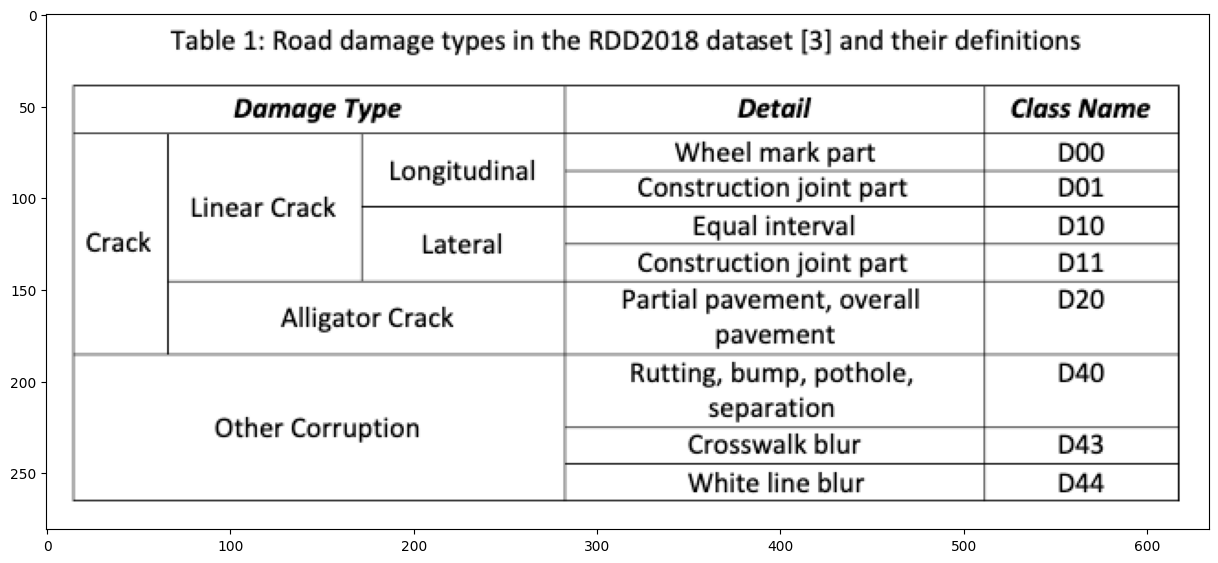

In [142]:
# Show annotations_meaning image
image = cv2.imread('../data/annotations_meaning.png')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(15, 15))
plt.imshow(image)